<a href="https://colab.research.google.com/github/anugrahatY/RaspberryPunch/blob/main/Experiment/lightgbm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# --- STEP 1: Install dependencies ---
!pip install lightgbm scikit-learn joblib shap matplotlib --quiet

In [22]:
# --- STEP 2: Imports ---
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import shap

In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- STEP 3: Synthetic data generator ---
def generate_synthetic_data(n_days=30, freq_minutes=5):
    rng = pd.date_range('2023-01-01', periods=int((24*60/freq_minutes)*n_days), freq=f'{freq_minutes}T')
    df = pd.DataFrame({'timestamp': rng})

    # irradiance: bell-shaped daily curve
    def irr_curve(ts):
        hour = ts.hour + ts.minute/60
        return np.maximum(0, 1000*np.exp(-0.5*((hour-13)/3)**2))
    df['irradiance'] = df['timestamp'].apply(irr_curve)

    cloud = np.clip(np.random.normal(1, 0.2, len(df)), 0.3, 1.2)
    df['irradiance'] *= cloud

    df['ambient_temp'] = 25 + 5*np.sin(2*np.pi*df['timestamp'].dt.dayofyear/365) + np.random.normal(0, 1, len(df))
    df['panel_temp'] = df['ambient_temp'] + 0.02*df['irradiance'] + np.random.normal(0, 0.5, len(df))

    df['pv_current'] = 5*(df['irradiance']/1000)*(1-0.005*(df['panel_temp']-25)) + np.random.normal(0,0.05,len(df))
    df['pv_voltage'] = 30 - 0.05*(df['panel_temp']-25) + 0.001*df['irradiance'] + np.random.normal(0,0.2,len(df))
    df['pv_power'] = df['pv_voltage']*df['pv_current']
    return df

df = generate_synthetic_data(30)
df.head()

/tmp/ipython-input-354618607.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rng = pd.date_range('2023-01-01', periods=int((24*60/freq_minutes)*n_days), freq=f'{freq_minutes}T')


,timestamp,irradiance,ambient_temp,panel_temp,pv_current,pv_voltage,pv_power
0,2023-01-01 00:00:00,0.091958,26.703112,26.827715,0.016533,29.836120,0.493275
1,2023-01-01 00:05:00,0.091704,24.315642,24.596755,0.067138,29.885525,2.006448
2,2023-01-01 00:10:00,0.120016,26.229428,26.527173,-0.036999,29.631976,-1.096359
3,2023-01-01 00:15:00,0.143535,25.270925,24.569304,0.114625,29.480737,3.379219
4,2023-01-01 00:20:00,0.128248,25.338262,25.752870,0.028482,29.597116,0.842992


In [24]:
# --- STEP 4: Feature engineering ---
def create_features(df, horizon_steps=3):
    df = df.copy()
    df['target_pv_power'] = df['pv_power'].shift(-horizon_steps)

    # time features
    df['hour'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute/60
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dayofweek'] = df['timestamp'].dt.dayofweek

    # lags/rolling
    df['pv_power_lag1'] = df['pv_power'].shift(1)
    df['pv_power_lag3'] = df['pv_power'].shift(3)
    df['pv_power_roll3'] = df['pv_power'].rolling(3).mean()

    df = df.dropna()
    features = ['irradiance','pv_voltage','pv_current','panel_temp','ambient_temp',
                'hour_sin','hour_cos','dayofweek',
                'pv_power_lag1','pv_power_lag3','pv_power_roll3']
    return df, features

df_feat, feature_cols = create_features(df, horizon_steps=3)
print("Features:", feature_cols)

Features: ['irradiance', 'pv_voltage', 'pv_current', 'panel_temp', 'ambient_temp', 'hour_sin', 'hour_cos', 'dayofweek', 'pv_power_lag1', 'pv_power_lag3', 'pv_power_roll3']


In [25]:
# --- STEP 5: Train LightGBM ---
X = df_feat[feature_cols]
y = df_feat['target_pv_power']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

train_set = lgb.Dataset(X_train,label=y_train)
valid_set = lgb.Dataset(X_test,label=y_test)

params = {
    'objective':'regression',
    'metric':['l1','rmse'],
    'learning_rate':0.05,
    'num_leaves':31,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'seed':RANDOM_SEED
}
model = lgb.train(params,train_set,num_boost_round=2000,
                  valid_sets=[train_set,valid_set],
                  callbacks=[lgb.log_evaluation(period=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2483
[LightGBM] [Info] Number of data points in the train set: 6907, number of used features: 11
[LightGBM] [Info] Start training from score 42.467919
[100]	training's l1: 5.31906	training's rmse: 8.4712	valid_1's l1: 6.72921	valid_1's rmse: 11.2654
[200]	training's l1: 4.58963	training's rmse: 7.10651	valid_1's l1: 6.71948	valid_1's rmse: 11.3381
[300]	training's l1: 4.08082	training's rmse: 6.18006	valid_1's l1: 6.79866	valid_1's rmse: 11.4957
[400]	training's l1: 3.66806	training's rmse: 5.45166	valid_1's l1: 6.832	valid_1's rmse: 11.5682
[500]	training's l1: 3.34895	training's rmse: 4.88408	valid_1's l1: 6.84882	valid_1's rmse: 11.6272
[600]	training's l1: 3.05854	training's rmse: 4.3886	valid_1's l1: 6.8627	valid_1's rmse: 11.6771
[700]	training's l1: 2.80036	training's rmse: 3.96889	valid_1's

In [26]:
# --- STEP 6: Evaluation ---
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mape = np.mean(np.abs((y_test-y_pred)/(y_test+1e-9)))*100
print(f"MAE={mae:.3f}, RMSE={rmse:.3f}, MAPE={mape:.2f}%")

MAE=7.080, RMSE=12.064, MAPE=115.72%


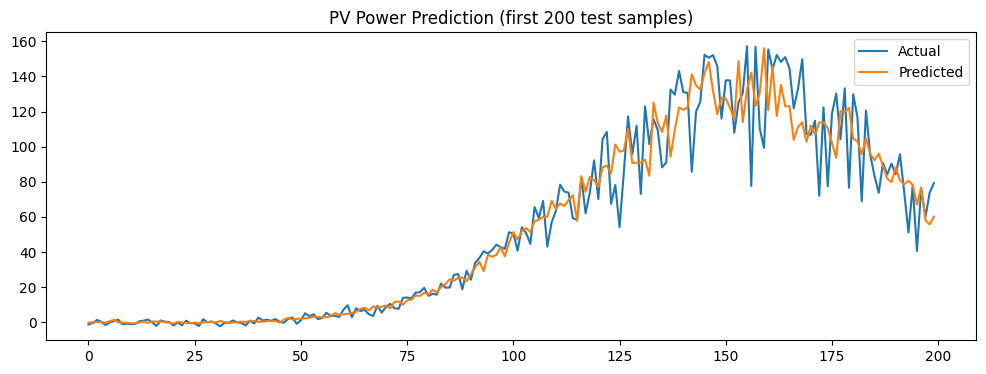

In [27]:
# Plot actual vs predicted
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:200],label="Actual")
plt.plot(y_pred[:200],label="Predicted")
plt.legend(); plt.title("PV Power Prediction (first 200 test samples)")
plt.show()

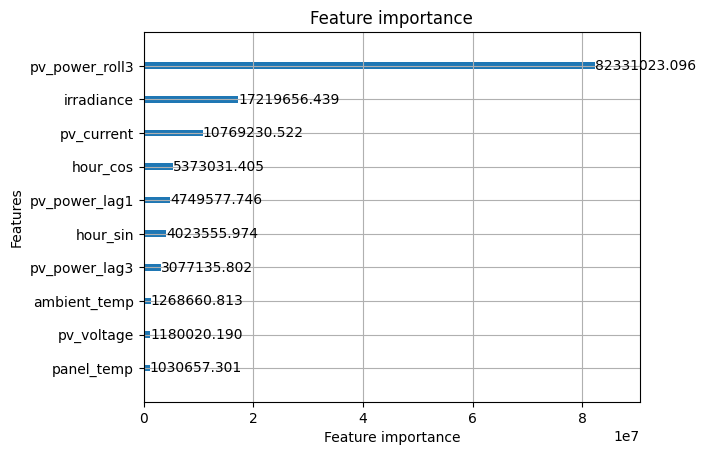

In [28]:
# Feature importance
lgb.plot_importance(model,max_num_features=10,importance_type='gain')
plt.show()


Anomalies detected: 32


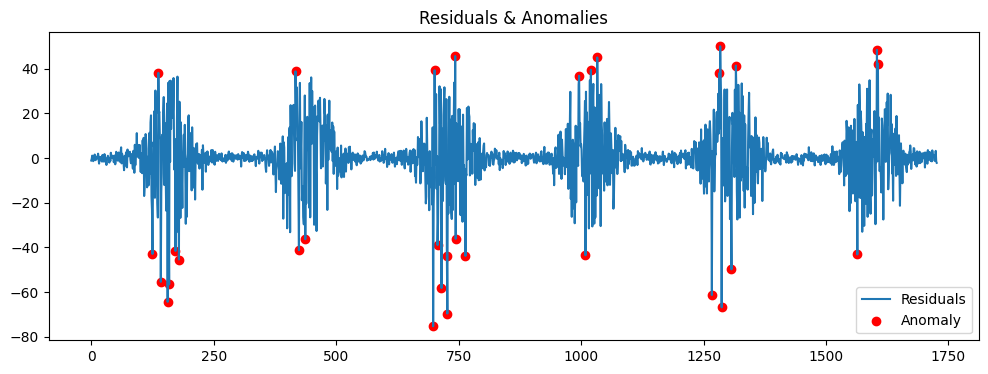

In [29]:
# --- STEP 7: Anomaly detection (simple residual z-score) ---
resid = y_test - y_pred
z = (resid - resid.mean())/(resid.std()+1e-9)
anomalies = np.abs(z)>3
print("Anomalies detected:", anomalies.sum())

plt.figure(figsize=(12,4))
plt.plot(resid.values,label="Residuals")
plt.scatter(np.where(anomalies)[0],resid[anomalies],color='red',label="Anomaly")
plt.legend(); plt.title("Residuals & Anomalies")
plt.show()


In [30]:
# --- STEP 8: Save & reload ---
model.save_model("lightgbm_pv_model.txt")
joblib.dump(feature_cols,"feature_columns.pkl")
print("Model + features saved.")


Model + features saved.
